# Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from functools import partial

from models.seq2seq_models.rnn_seq2seq import RNNSeq2Seq
from models.seq2seq_models.transformer import Transformer, Utils

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Data

In [3]:
# !wget https://www.manythings.org/anki/spa-eng.zip

In [4]:
# !unzip spa-eng.zip

In [5]:
data = pd.read_csv('spa.txt', delimiter='\t', header=None, names=['english', 'spanish', 'from'])

In [6]:
data.head()

,english,spanish,from
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)


In [7]:
len(data)

141543

In [8]:
data.drop('from', axis=1, inplace=True)

In [9]:
data.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [10]:
data['english'] = data['english'].apply(lambda x: 'SOS ' + x + ' EOS')
data['spanish'] = data['spanish'].apply(lambda x: 'SOS ' + x + ' EOS')

In [11]:
len(data['english']), len(data['spanish'])

(141543, 141543)

In [12]:
for i in range(1000, 1005):
    print('English: ', data['english'][i])
    print('Spanish: ', data['spanish'][i])
    print('\n')

English:  SOS Please go. EOS
Spanish:  SOS Por favor, vete. EOS


English:  SOS Please go. EOS
Spanish:  SOS Por favor, márchate. EOS


English:  SOS Please go. EOS
Spanish:  SOS Por favor, váyase. EOS


English:  SOS Put it on. EOS
Spanish:  SOS Póntelo. EOS


English:  SOS Put it on. EOS
Spanish:  SOS Póngaselo. EOS




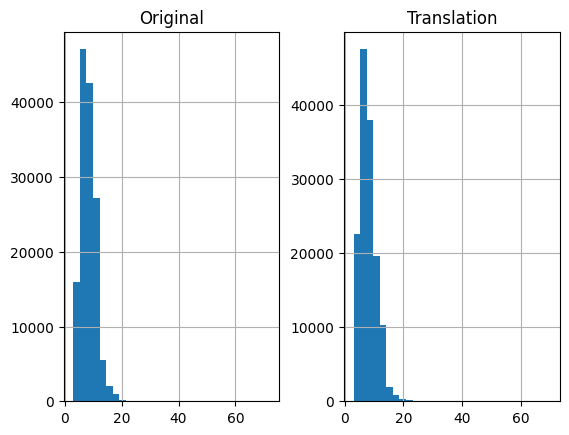

In [13]:
text_word_count = []
summary_word_count = []

for i in data['english']:
    text_word_count.append(len(i.split()))

for i in data['spanish']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Original': text_word_count, 'Translation': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [14]:
text_word_count = np.array(text_word_count)
summary_word_count = np.array(summary_word_count)
print(f'Text | Mean: {text_word_count.mean()} | Std: {text_word_count.std()} | Min: {text_word_count.min()} | Max: {text_word_count.max()}')
print(f'Summary | Mean: {summary_word_count.mean()} | Std: {summary_word_count.std()} | Min: {summary_word_count.min()} | Max: {summary_word_count.max()}')

Text | Mean: 8.216874024148138 | Std: 2.6011613040560078 | Min: 3 | Max: 72
Summary | Mean: 7.982153833110786 | Std: 2.7531145178291636 | Min: 3 | Max: 70


In [15]:
max_len_text = 71
max_len_summary = 70

In [16]:
x_tr, x_val, y_tr, y_val = train_test_split(data['english'], data['spanish'], test_size=0.1,
                                            random_state=0, shuffle=True)

In [17]:
pd.concat([x_tr, y_tr], axis=1)

,english,spanish
107290,SOS She was carrying the baby on her back. EOS,SOS Ella cargaba al bebé en su espalda. EOS
107013,SOS Let's not talk about your job tonight. EOS,SOS Mejor no hablemos de trabajo esta noche. EOS
22569,SOS This just got ugly. EOS,SOS Esto realmente se puso feo. EOS
6226,SOS She's my wife. EOS,SOS Ella es mi mujer. EOS
121951,SOS Tom is going to stay here until next Monday. EOS,SOS Tomás se va a quedar acá hasta el lunes que viene. EOS
...,...,...
41993,SOS Tom is building a wall. EOS,SOS Tom está levantando un muro. EOS
97639,"SOS The book doesn't have a title, yet. EOS","SOS El libro no tiene título, aún. EOS"
95939,SOS He's not good at remembering names. EOS,SOS Él no es bueno para recordar nombres. EOS
117952,SOS Tom doesn't appear to be paying attention. EOS,SOS Tom no parece estar prestando atención. EOS


In [18]:
tokenizer = {}
SRC_LANGUAGE = 'english'
TGT_LANGUAGE = 'spanish'
tokenizer[SRC_LANGUAGE] = get_tokenizer("spacy", "en_core_web_sm")
tokenizer[TGT_LANGUAGE] = get_tokenizer("spacy", "es_core_news_sm")

In [19]:
tokenized_x_tr = x_tr.apply(lambda x: tokenizer[SRC_LANGUAGE](x))
tokenized_x_val = x_val.apply(lambda x: tokenizer[SRC_LANGUAGE](x))
tokenized_y_tr = y_tr.apply(lambda x: tokenizer[TGT_LANGUAGE](x))
tokenized_y_val = y_val.apply(lambda x: tokenizer[TGT_LANGUAGE](x))

In [20]:
train_df = pd.concat([tokenized_x_tr, tokenized_y_tr], axis=1)
val_df = pd.concat([tokenized_x_val, tokenized_y_val], axis=1)

In [21]:
train_df.head()

,english,spanish
107290,"[SOS, She, was, carrying, the, baby, on, her, back, ., EOS]","[SOS, Ella, cargaba, al, bebé, en, su, espalda, ., EOS]"
107013,"[SOS, Let, 's, not, talk, about, your, job, tonight, ., EOS]","[SOS, Mejor, no, hablemos, de, trabajo, esta, noche, ., EOS]"
22569,"[SOS, This, just, got, ugly, ., EOS]","[SOS, Esto, realmente, se, puso, feo, ., EOS]"
6226,"[SOS, She, 's, my, wife, ., EOS]","[SOS, Ella, es, mi, mujer, ., EOS]"
121951,"[SOS, Tom, is, going, to, stay, here, until, next, Monday, ., EOS]","[SOS, Tomás, se, va, a, quedar, acá, hasta, el, lunes, que, viene, ., EOS]"


In [22]:
vocab = {}
src_vocab_size = 10_000
tgt_vocab_size = 10_000
max_seq_len = 72

PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3
special_tokens = ['PAD', 'UNK', 'SOS', 'EOS']

In [23]:
def yield_tokens(dataset, language):
    n = len(dataset)
    i = 0
    while i < n:
        yield dataset.iloc[i][language]
        i += 1

In [24]:
src_iterator = yield_tokens(train_df, SRC_LANGUAGE)
tgt_iterator = yield_tokens(train_df, TGT_LANGUAGE)

In [25]:
vocab[SRC_LANGUAGE] = build_vocab_from_iterator(src_iterator, min_freq=1, specials=special_tokens, special_first=True, max_tokens=src_vocab_size)
vocab[TGT_LANGUAGE] = build_vocab_from_iterator(tgt_iterator, min_freq=1, specials=special_tokens, special_first=True, max_tokens=tgt_vocab_size)

In [26]:
vocab[SRC_LANGUAGE].set_default_index(UNK_IDX)
vocab[TGT_LANGUAGE].set_default_index(UNK_IDX)

In [27]:
def collate_fn(batch, vocabulary):
    batch_size = len(batch)
    srcs, tgts = zip(*batch)
    src_vectors = torch.zeros((batch_size, max_seq_len), dtype=torch.long, device=device)
    tgt_vectors = torch.zeros((batch_size, max_seq_len), dtype=torch.long, device=device)

    for i in range(batch_size):
        src_vectors[i] = torch.tensor((vocabulary[SRC_LANGUAGE](srcs[i]) + [0] * (max_seq_len - len(srcs[i])))[:max_seq_len], dtype=torch.long, device=device)
        tgt_vectors[i] = torch.tensor((vocabulary[TGT_LANGUAGE](tgts[i]) + [0] * (max_seq_len - len(tgts[i])))[:max_seq_len], dtype=torch.long, device=device)

    return src_vectors, tgt_vectors    

In [28]:
class SentencesDataset(torch.nn.Module):
    def __init__(self, dataframe):
        super(SentencesDataset, self).__init__()
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        english, spanish = self.dataframe.iloc[idx]
        return english, spanish

In [29]:
train_ds = SentencesDataset(train_df)
val_ds = SentencesDataset(val_df)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, vocabulary=vocab))
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, vocabulary=vocab))

In [30]:
def accuracy(outputs, targets):
    flattened_outputs = outputs.argmax(dim=-1).flatten()
    flattened_targets = targets[:, 1:].flatten()
    accuracies = flattened_outputs.eq(flattened_targets)
    mask = torch.logical_not(flattened_outputs.eq(0))
    accuracies = torch.logical_and(mask, accuracies)
    return (accuracies.sum() / mask.sum()).item()

In [31]:
def train_and_validate(model_, optimizer_, criterion_, train_loader_, val_loader_, epochs_, device_, model_type='rnn'):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for (inputs, targets) in tqdm(train_loader_, total=len(train_loader_)):
            inputs, targets = inputs.to(device_), targets.to(device_)
            outputs = model_(inputs, targets[:, :-1])
            loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
            total_train_loss += loss.item()
            optimizer_.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1.0)
            optimizer_.step()

        model_.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader_:
                inputs, targets = inputs.to(device_), targets.to(device_)
                if model_type == 'transformer':
                    outputs = model_(inputs, targets[:, :-1])
                else:
                    outputs = model_(inputs, targets[:, :-1], 0)
                loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
                total_val_loss += loss.item()
                total_val_acc += accuracy(outputs, targets)

        total_train_loss = total_train_loss / len(train_loader_)
        total_val_loss = total_val_loss / len(val_loader_)
        total_val_acc = total_val_acc / len(val_loader_)

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)
        val_accs.append(total_val_acc)
        print(
            f'Epoch: {epoch + 1} / {epochs_} | Train loss: {total_train_loss} | Val loss: {total_val_loss} | Val acc: {total_val_acc}')
    return train_losses, val_losses, val_accs


In [32]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [56]:
def decode_sequence(input_seq, model_, rnn_type='rnn'):
    model_.eval()
    with torch.no_grad():
        if rnn_type == 'lstm':
            enc_output, hidden, cell_state = model_.encoder(input_seq.to(device))
        else:
            enc_output, hidden = model_.encoder(input_seq.to(device))
    
        target_seq = torch.zeros(1, dtype=torch.int64).to(device)
        target_seq[0] = vocab[SRC_LANGUAGE]['SOS']
    
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            if rnn_type == 'lstm':
                prediction, hidden, _ = model_.decoder(target_seq, enc_output, hidden, cell_state)
            else:
                prediction, hidden = model_.decoder(target_seq, enc_output, hidden)
            prediction_index = prediction.argmax(dim=-1)[0].item()
            predicted_word = vocab[TGT_LANGUAGE].lookup_token(prediction_index)
    
            if predicted_word != 'EOS':
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'EOS' or len(decoded_sentence.split()) >= max_len_summary - 1:
                stop_condition = True
    
            target_seq = torch.zeros(1, dtype=torch.int64).to(device)
            target_seq[0] = prediction_index
    
        return decoded_sentence


In [34]:
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
        if (i != 0 and i != vocab[TGT_LANGUAGE]['SOS']) and i != vocab[TGT_LANGUAGE]['EOS']:
            new_string = new_string + vocab[TGT_LANGUAGE].lookup_token(i) + ' '
    return new_string


def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + vocab[SRC_LANGUAGE].lookup_token(i) + ' '
    return new_string


In [35]:
len(vocab[SRC_LANGUAGE]), len(vocab[TGT_LANGUAGE])

(9998, 9998)

# RNN Seq2Seq

In [47]:
epochs = 3
embedding_dim = 512
hidden_dim = 2048
enc_layers = 6
dec_layers = 6
enc_vocab_size = len(vocab[SRC_LANGUAGE])
dec_vocab_size = len(vocab[TGT_LANGUAGE])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [48]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:


100%|██████████| 3981/3981 [44:31<00:00,  1.49it/s]


Epoch: 1 / 3 | Train loss: 5.482210037367514 | Val loss: 5.385112163982865 | Val acc: 0.01823626436150168


100%|██████████| 3981/3981 [44:37<00:00,  1.49it/s]


Epoch: 2 / 3 | Train loss: 5.604011346394918 | Val loss: 5.395245750117248 | Val acc: 0.0180913873151382


100%|██████████| 3981/3981 [44:42<00:00,  1.48it/s]


Epoch: 3 / 3 | Train loss: 5.377081498642179 | Val loss: 5.3781067749178435 | Val acc: 0.01754439512843741


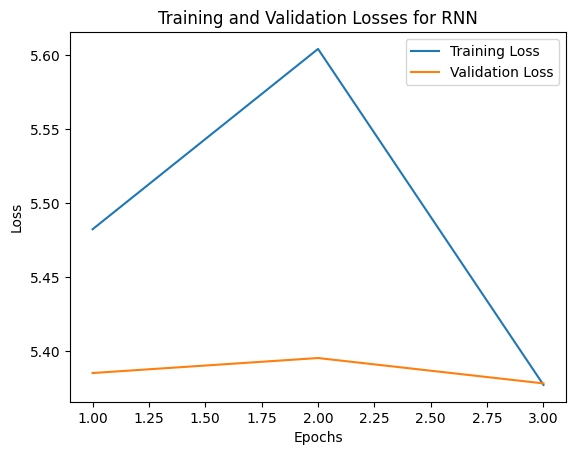

In [49]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [ ]:
english, spanish = next(iter(val_loader))

In [57]:
for i in range(english.shape[0]):
    print('Review: ', seq2text(english[i]))
    print('Original summary: ', seq2summary(spanish[i]))
    print('Predicted summary: ', decode_sequence(english[i].reshape(1, -1), model))
    print('\n')
    if i == 0:
        break

Review:  SOS That 's a difficult question . EOS 
Original summary:  Es una pregunta difícil . 
Predicted summary:   ¿ que es . .




# Transformer

In [36]:
epochs = 3
embedding_dim = 512
hidden_dim = 2048
enc_layers = 6
dec_layers = 6
enc_vocab_size = len(vocab[SRC_LANGUAGE])
dec_vocab_size = len(vocab[TGT_LANGUAGE])
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(enc_vocab_size=enc_vocab_size, 
                    dec_vocab_size=dec_vocab_size, 
                    enc_len_seq=max_seq_len, 
                    dec_len_seq=max_seq_len - 1, 
                    embedding_dim=embedding_dim, 
                    enc_depth=enc_layers, 
                    dec_depth=dec_layers,
                    dropout=dropout,
                    hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [37]:
print('Transformer Start Training:')
transformer_train_losses, transformer_val_losses, transformer_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device, model_type='transformer')

Transformer Start Training:


100%|██████████| 3981/3981 [05:25<00:00, 12.24it/s]


Epoch: 1 / 3 | Train loss: 3.0102887877984372 | Val loss: 2.085398345714767 | Val acc: 0.07534103917954468


100%|██████████| 3981/3981 [05:32<00:00, 11.99it/s]


Epoch: 2 / 3 | Train loss: 1.9995721781921578 | Val loss: 1.69604284714899 | Val acc: 0.08164987514640623


100%|██████████| 3981/3981 [05:31<00:00, 12.03it/s]


Epoch: 3 / 3 | Train loss: 1.6755950214035755 | Val loss: 1.5145276651694597 | Val acc: 0.08489741544758493


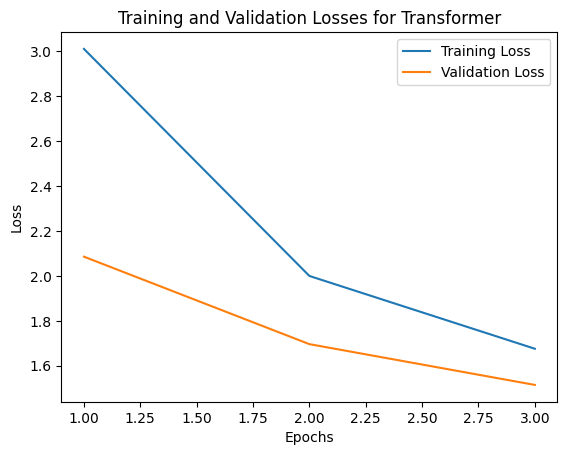

In [38]:
plot_losses('Transformer', transformer_train_losses, transformer_val_losses, epochs)

In [42]:
def decode_sequence(input_seq, model_):
    model_.eval()
    with torch.no_grad():
        input_seq = input_seq.to(device)
        target_seq = torch.zeros((1,1), dtype=torch.int64).to(device)
        target_seq[:, 0] = vocab[TGT_LANGUAGE]['EOS']
        padding = torch.zeros((1, max_seq_len - 2), dtype=torch.int64).to(device)
        target_seq = torch.cat((target_seq, padding), 1)
    
        decoded_sentence = ''
        for idx in range(max_len_summary - 2):
            trg_mask = Utils.make_combined_mask(target_seq)
            prediction = model_(input_seq, target_seq, look_ahead_mask=trg_mask)
            prediction_index = prediction.argmax(dim=-1)[0][idx].item()
            predicted_word = vocab[TGT_LANGUAGE].lookup_token(prediction_index)
    
            if predicted_word != 'EOS':
                target_seq[:, idx + 1] = prediction_index
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'EOS' or len(decoded_sentence.split()) >= max_len_summary - 1:
                break
    
        return decoded_sentence.replace('SOS', '').replace('EOS', '').strip()

In [43]:
english, spanish = next(iter(val_loader))

In [44]:
for i in range(english.shape[0]):
    print('Review: ', seq2text(english[i]))
    print('Original summary: ', seq2summary(spanish[i]))
    print('Predicted summary: ', decode_sequence(english[i].reshape(1, -1), model))
    print('\n')
    if i == 0:
        break

Review:  SOS That 's a difficult question . EOS 
Original summary:  Es una pregunta difícil . 
Predicted summary:  es una pregunta difícil .


